In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.cross_validation import cross_val_predict
import re

/Users/dwhitehead/Documents/github/hearthstone_analytics/vhearthstone_analytics/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def load_data(wdir):
    filename = wdir + 'clean_cards.csv'
    df = pd.DataFrame.from_csv(filename, sep='\t', encoding='utf-8')
    return df

In [3]:
def filter_data(df):
    # remove non-minions
    df = df[df['type'].isin(['minion'])]
    
    # remove cost outliers
    df = df[df['cost'] <= 10]
    
    # remove boss
    df['text'].fillna(
        value='',
        inplace=True
    )
    df['boss'] = df['text'].apply(lambda x: 1 if 'boss' in x else 0)
    df = df[df['boss'] == 0]
    
    # remove non-collectible cards
    df = df[df['collectible'] == True]
    
    # remove weird sets
    collectibles = ['core', 'expert1', 'naxx', 'gvg', 'brm', 'tgt', 'loe', 'promo', 'reward', 'og']
    df = df[df['set'].isin(collectibles)]
    
    # removing individual cards
    boss_cards = ['animated_statue']
    removed_cards = ['avatar_of_the_coin']
    outliers = ['the_ancient_one']
    hero_summons = [
        'searing_totem',
        'stoneclaw_totem',
        'wrath_of_air_totem',
        'healing_totem',
        'silver_hand_recruit'
    ]
    card_exclusions = boss_cards + removed_cards + outliers + hero_summons
    df = df[~df['name'].isin(card_exclusions)]
    
    return df

In [4]:
def filter_text_cards(text):
    text = text.split(' ')
    if text == ['']:
        return True
    words = [
        'charge',
        'taunt',
        'stealth',
        'divine_shield',
        'windfury',
        'overload'
    ]
    for item in text:
        if item not in ['<b>' + x + '</b>' for x in words]:
            return False
        else:
            continue
    
    return True

In [5]:
def add_features(df):
    # card draw
    df['self_card_draw'] = df['text'].apply(
        lambda x: 1 if ('draw' in x
            and 'card' in x
            and 'opponent' not in x
        ) else 0
    )
    # health
    df['self_restore_health'] = df['text'].apply(
        lambda x: int(
            x[x.find('_health')-1:x.find('_health')]
        ) if ('restore' in x
            and 'health' in x
            and 'opponent' not in x
        ) else 0
    )
    # damage
    df['deal_damage'] = df['text'].apply(
        lambda x: int(
            x[x.find('_damage')-1:x.find('_damage')]
        ) if ('deal' in x and 'damage' in x) else 0
    )
    # attack buff
    df['attack_buff'] = df['text'].apply(
        lambda x: int(
            x[x.find('_attack')-1:x.find('_attack')]
        ) if ('+' in x and 'attack' in x) else 0
    )
    # attack buff range
    # spell damage
    df['spell_damage'] = df['text'].apply(
        lambda x: int(
            x[x.find('spell_damage_+') + len('spell_damage_+'):x.find('spell_damage_+') + len('spell_damage_+') + 1]
        ) if ('spell_damage_+' in x) else 0
    )
    # summon
    df['self_summon'] = df['text'].apply(
        lambda x: int(
            x[x.find('_summon_a_') + len('_summon_a_'):x.find('_summon_a_') + len('_summon_a_') + 3]
        ) if ('_summon_a_' in x and 'opponent' not in x) else 0
    )
    # other ability
    df['other_ability'] = df['text'].apply(
        lambda x: int(x[x.find('_damage')-1:x.find('_damage')]) if ('deal' in x
            and 'damage' in x
        ) else 0
    )
    # other ability
    df['other_ability'] = df['text'].apply(
        lambda x: int(x[x.find('_damage')-1:x.find('_damage')]) if ('deal' in x
            and 'damage' in x
        ) else 0
    )
    # other ability
    df['other_ability'] = df['text'].apply(
        lambda x: int(x[x.find('_damage')-1:x.find('_damage')]) if ('deal' in x
            and 'damage' in x
        ) else 0
    )
    
    
    return df

In [6]:
def train_cv_test_split(df, split_sizes=[1.0, 0.0, 0.0]):
    assert sum(split_sizes) == 1
    train_size = split_sizes[0]
    cv_size = split_sizes[1]
    test_size = split_sizes[2]
    train, test = train_test_split(df, test_size=test_size)
    train, cv = train_test_split(train, test_size=cv_size)
    return train, cv, test

In [7]:
def human_readable_coefficients(df, predictor):
    return pd.DataFrame(
        zip(df.columns, predictor.coef_[0]),
        columns=['features', 'predicted_coefficients']
    )

In [8]:
# regex examples
# >>> re.findall(r'\d+', '<b>battlecry:</b>_summon_a_1/1_murloc_scout.')
# ['1', '1']

In [19]:
print df_og[df_og['name'] == 'totem_golem']

     enraged  evil_glow  set  inspire  durability                  text  \
399        0          0  tgt        0           0  <b>overload:_(1)</b>   

     secret  freeze  cost  divine_shield   ...            name  \
399       0       0   2.0              0   ...     totem_golem   

             artist morph windfury  rarity  tag_one_turn_effect   race  aura  \
399  steve_prescott     0        0  common                    0  totem     0   

     battlecry  silence  
399          0        0  

[1 rows x 42 columns]


In [16]:
wdir = '/Users/dwhitehead/Documents/github/hearthstone_analytics/'
df_og = load_data(wdir)
df = filter_data(df_og)
df['no_text'] = df['text'].apply(lambda x: 1 if filter_text_cards(x) else 0)
df['health_x_taunt'] = df['health'] * df['taunt']
df = df[df['no_text'] == 1]
# df = add_features(df)
df['intercept'] = 1
dep_var = ['cost']
indep_vars = [
    'attack',
    'health',
    'charge',
    'taunt',
    'health_x_taunt',
    'stealth',
    'divine_shield',
    'intercept'
]
print df[dep_var].sample(5)
print df[indep_vars + ['name', 'no_text']].sample(5)

print df[df['no_text'] == 1][indep_vars + ['text', 'name', 'collectible']]

      cost
964    7.0
2126   2.0
745    8.0
156    6.0
136    9.0
      attack  health  charge  taunt  health_x_taunt  stealth  divine_shield  \
1866     2.0     2.0       0      1             2.0        0              0   
534     10.0    10.0       0      0             0.0        0              0   
568      1.0     1.0       0      0             0.0        0              0   
1053     0.0     2.0       0      1             2.0        0              0   
2134     7.0     4.0       0      0             0.0        0              0   

      intercept               name  no_text  
1866          1    frostwolf_grunt        1  
534           1  faceless_behemoth        1  
568           1               wisp        1  
1053          1       target_dummy        1  
2134          1          salty_dog        1  
      attack  health  charge  taunt  health_x_taunt  stealth  divine_shield  \
4        5.0     2.0       0      0             0.0        0              0   
20       4.0     5.0     

In [17]:
lr = linear_model.LinearRegression(
    fit_intercept=False,
    normalize=False,
    copy_X=True,
    n_jobs=1
)
lr.fit(
    X=df[indep_vars],
    y=df[dep_var]
)
df_coefficients = human_readable_coefficients(
    df[indep_vars],
    lr
)
df['predictions'] = lr.predict(df[indep_vars])
colss = dep_var + indep_vars + ['name', 'predictions']
df_coefficients

,features,predicted_coefficients
0,attack,0.578518
1,health,0.518791
2,charge,1.082514
3,taunt,-0.076923
4,health_x_taunt,0.039376
5,stealth,0.207939
6,divine_shield,0.858294
7,intercept,-0.562165


In [18]:
smlr = sm.OLS(df[dep_var], df[indep_vars])
result = smlr.fit()
print result.summary()

                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     150.4
Date:                Thu, 23 Jun 2016   Prob (F-statistic):           9.09e-35
Time:                        23:28:22   Log-Likelihood:                -53.299
No. Observations:                  66   AIC:                             122.6
Df Residuals:                      58   BIC:                             140.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
attack             0.5785      0.041     14.

[('red', 'attack'), ('blue', 'health'), ('green', 'charge'), ('yellow', 'taunt'), ('pink', 'stealth'), ('grey', 'divine_shield')]


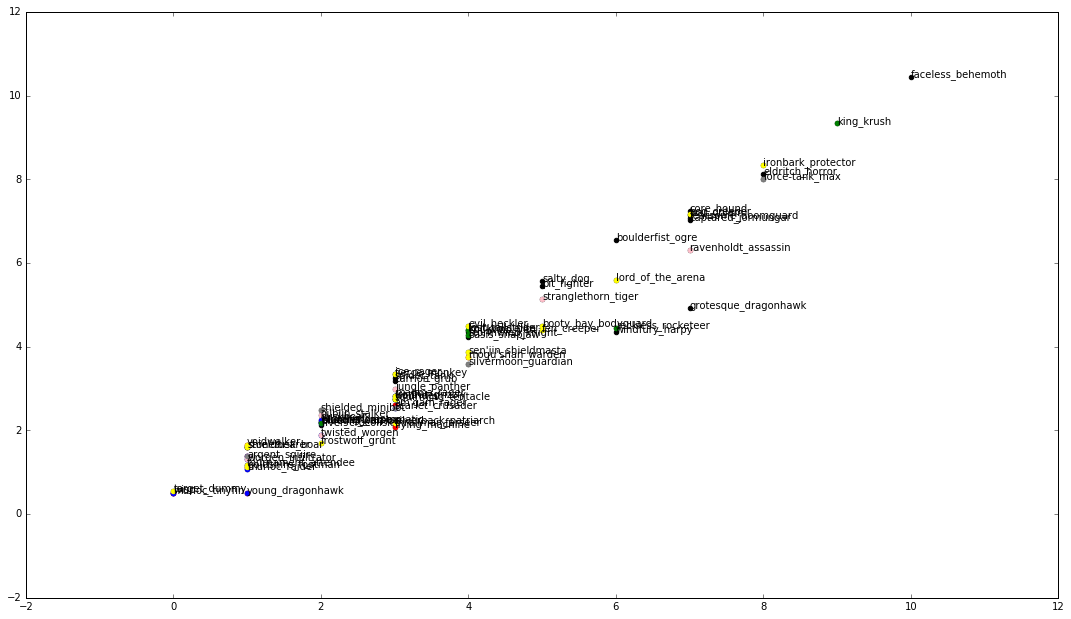

In [12]:
colors = [
    'red',
    'blue',
    'green',
    'yellow',
    'pink',
    'grey'
]
print zip(colors, indep_vars[:-1])
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.scatter(
    x=df['cost'],
    y=df['predictions'],
    color='black'
)
for i, var in enumerate(indep_vars[:-1]):
    ax.scatter(
        x=df[df[var] == 1]['cost'],
        y=df[df[var] == 1]['predictions'],
        color=colors[i]
    )
for index, row in df.iterrows():
    ax.annotate(
        row['name'],
        xy= (float(row['cost']), float(row['predictions']))
    )
plt.show()

In [14]:
for i in xrange(0,11):
    print
    cost = i
    mean = df[df['cost'] == i]['predictions'].mean()
    std = df[df['cost'] == i]['predictions'].std()
    print 'cost', cost
    print '-'*20
    print 'mean', mean
    print 'std', std    
    for idx, row in df[df['cost'] == i].sort(columns='predictions', ascending=False).iterrows():
        print '-'*5
        print 'name', row['name']
        print 'text', row['text']
        dev = (row['predictions'] - mean) / std
        print 'dev', dev
#         if abs(dev) > 1.5:
#             print row[colss + ['text']]
#             print 'dev', dev


cost 0
--------------------
mean 0.521947384308
std 0.0214394671549
-----
name target_dummy
text <b>taunt</b>
dev 1.15470053838
-----
name murloc_tinyfin
text 
dev -0.57735026919
-----
name wisp
text 
dev -0.57735026919

cost 1
--------------------
mean 1.27142276715
std 0.356335712545
-----
name voidwalker
text <b>taunt</b>
dev 1.06745837095
-----
name stonetusk_boar
text <b>charge</b>
dev 0.926173189075
-----
name shieldbearer
text <b>taunt</b>
dev 0.915415762623
-----
name argent_squire
text <b>divine_shield</b>
dev 0.301839168064
-----
name worgen_infiltrator
text <b>stealth</b>
dev 0.100767831091
-----
name tournament_attendee
text <b>taunt</b>
dev -0.255112018565
-----
name goldshire_footman
text <b>taunt</b>
dev -0.407154626887
-----
name murloc_raider
text 
dev -0.511366035096
-----
name young_dragonhawk
text <b>windfury</b>
dev -2.13802164125

cost 2
--------------------
mean 2.15878305939
std 0.220401730684
-----
name shielded_minibot
text <b>divine_shield</b>
dev 1.47588922

/Users/dwhitehead/Documents/github/hearthstone_analytics/vhearthstone_analytics/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [75]:
print df[df['cost'] > 10][dep_var + indep_vars + ['name']]

      cost  attack  health  charge  taunt  stealth  divine_shield  intercept  \
573   50.0    20.0    20.0       0      0        0              0          1   
615   25.0     8.0     8.0       0      0        0              0          1   
1404  12.0     8.0     8.0       0      0        0              0          1   
2084  12.0     8.0     8.0       0      0        0              0          1   

                 name  
573          golemagg  
615      molten_giant  
1404  clockwork_giant  
2084   mountain_giant  


In [77]:
print df[df['predictions'] > 10][dep_var + indep_vars + ['name', 'predictions']]

      cost  attack  health  charge  taunt  stealth  divine_shield  intercept  \
47    10.0     1.0    80.0       0      1        0              0          1   
573   50.0    20.0    20.0       0      0        0              0          1   
680   10.0    12.0    12.0       0      0        0              0          1   
871   10.0     2.0    95.0       0      1        0              0          1   
1080  10.0    12.0    12.0       0      0        0              0          1   
1168   9.0    30.0    30.0       0      0        0              0          1   
1196  10.0     9.0    80.0       0      0        0              0          1   
1276  10.0    11.0    11.0       0      0        0              0          1   

                       name  predictions  
47      gearmaster_mechazod    11.951274  
573                golemagg    17.768093  
680   deathwing,_dragonlord    10.945346  
871     gearmaster_mechazod    14.654265  
1080              deathwing    10.945346  
1168        the_ancie

In [99]:
for col in df.columns:
    print df[df.name == 'gearmaster_mechazod'][col]

47     0
871    0
Name: enraged, dtype: int64
47     0
871    0
Name: evil_glow, dtype: int64
47     tb
871    tb
Name: set, dtype: object
47     0
871    0
Name: inspire, dtype: int64
47     0
871    0
Name: durability, dtype: int64
47     <b>boss</b>\nat_the_beginning_of_each_turn,_me...
871    <b>boss</b>\nmechazod_wins_if_he_defeats_eithe...
Name: text, dtype: object
47     0
871    0
Name: secret, dtype: int64
47     0
871    0
Name: freeze, dtype: int64
47     10.0
871    10.0
Name: cost, dtype: float64
47     0
871    0
Name: divine_shield, dtype: int64
47     0
871    0
Name: immunetospellpower, dtype: int64
47     0
871    0
Name: adjacent_buff, dtype: int64
47              hrw02_1
871    tb_coop_mechazod
Name: id, dtype: object
47     NaN
871    NaN
Name: playerClass, dtype: object
47     0
871    0
Name: choose_one, dtype: int64
47     0
871    0
Name: ritual, dtype: int64
47     0
871    0
Name: poisonous, dtype: int64
47     0
871    0
Name: ai_must_play, dtype: int64
47  

In [85]:
print list(df['playerClass'].unique())

[u'priest', nan, u'warlock', u'rogue', u'shaman', u'hunter', u'paladin', u'warrior', u'druid', u'dream', u'mage']


In [86]:
print df[df.invisibledeathrattle > 0]

      enraged  evil_glow   set  inspire  durability  secret  freeze  cost  \
31          0          0  naxx        0           0       0       0   0.0   
47          0          0    tb        0           0       0       0  10.0   
475         0          0   brm        0           0       0       0   2.0   
910         0          0   brm        0           0       0       0   1.0   
916         0          0  naxx        0           0       0       0   3.0   
1037        0          0  naxx        0           0       0       0   3.0   
1865        0          0   brm        0           0       0       0   2.0   
2023        0          0   brm        0           0       0       0   1.0   

      divine_shield  immunetospellpower     ...       morph windfury  \
31                0                   0     ...           0        0   
47                0                   0     ...           0        0   
475               0                   0     ...           0        0   
910               

In [110]:
l = [type(x) for x in df.text.unique()]
for i in df.text.unique():
    if isinstance(i, float):
        print i, type(i)

nan <type 'float'>


In [121]:

print df[df['text'].isnull() == True]

Empty DataFrame
Columns: [enraged, evil_glow, set, inspire, durability, text, secret, freeze, cost, divine_shield, immunetospellpower, adjacent_buff, id, playerClass, choose_one, ritual, poisonous, ai_must_play, charge, overload, attack, invisibledeathrattle, health, spellDamage, combo, type, taunt, topdeck, forgetful, deathrattle, stealth, name, artist, morph, windfury, rarity, tag_one_turn_effect, race, aura, battlecry, silence]
Index: []

[0 rows x 41 columns]


In [81]:
print df[df['name'] == 'living_lava'][colss + ['set']]

      cost  attack  health  charge  taunt  stealth  divine_shield  intercept  \
1940   0.0     6.0     6.0       0      1        0              0          1   

             name  predictions  set  
1940  living_lava     5.811602  brm  


In [14]:
print df.columns

Index([             u'enraged',            u'evil_glow',
                        u'set',              u'inspire',
                 u'durability',                 u'text',
                     u'secret',               u'freeze',
                       u'cost',        u'divine_shield',
         u'immunetospellpower',        u'adjacent_buff',
                         u'id',          u'playerClass',
                 u'choose_one',               u'ritual',
                  u'poisonous',         u'ai_must_play',
                     u'charge',             u'overload',
                     u'attack', u'invisibledeathrattle',
                     u'health',          u'spellDamage',
                      u'combo',                 u'type',
                      u'taunt',              u'topdeck',
                  u'forgetful',          u'deathrattle',
                    u'stealth',                 u'name',
                     u'artist',                u'morph',
                   u'windfury',

In [45]:
minions = ['murloc_tidehunter', 'sheep', 'northshire_cleric', 'frog', 'voodoo_doctor', 'elven_archer', 'kobold_geomancer']
df = add_features(df)
addl_cols = ['name', 'battlecry', 'self_card_draw', 'self_restore_health', 'deal_damage', 'spellDamage', 'attack_buff']
# print df['self_card_draw'].sample(5)
print df[df['name'].isin(minions)][addl_cols]

                   name  battlecry  self_card_draw  self_restore_health  \
373   northshire_cleric          0               1                    0   
696                frog          0               0                    0   
798        elven_archer          1               0                    0   
1027              sheep          0               0                    0   
1146      voodoo_doctor          1               0                    2   
1433  murloc_tidehunter          1               0                    0   
1667   kobold_geomancer          0               0                    0   

      deal_damage  spellDamage  attack_buff  
373             0            0            0  
696             0            0            0  
798             1            0            0  
1027            0            0            0  
1146            0            0            0  
1433            0            0            0  
1667            0            1            0  
